# 阶段3：时间序列模型训练

本notebook完成以下任务：
1. 加载数据和Top-M特征
2. 为每个组独立创建时间序列
3. 实现LSTM模型
4. 实现GRU模型
5. 实现Transformer模型
6. 训练所有模型（使用训练集，训练验证集用于early stopping）
7. 在验证集上评估和选择最佳模型
8. 保存模型


In [1]:
# 导入必要的库和配置
%run 00_config_and_setup.ipynb

import config
from utils.data_utils import load_intermediate, save_intermediate
from utils.model_utils import create_sequences_by_group, evaluate_model

# TensorFlow/Keras相关
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam

# 设置TensorFlow随机种子
tf.random.set_seed(config.RANDOM_STATE)

print("准备开始时间序列模型训练...")
print(f"TensorFlow版本: {tf.__version__}")


✓ 所有库导入完成
✓ 配置文件加载完成
项目根目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025
输出目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs
中间结果目录: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
✓ 显示选项设置完成
✓ 输出目录创建完成
  - 中间结果: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate
  - 模型文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models
  - 报告文件: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\reports
  - 可视化: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\visualizations
✓ 随机种子设置为: 42
✓ 可视化样式设置完成: seaborn-v0_8
✓ 工具函数导入完成
准备开始时间序列模型训练...
TensorFlow版本: 2.20.0


## 1. 加载数据


In [2]:
# 加载所有数据集和Top-M特征
train_data = load_intermediate('train_data')
train_val_data = load_intermediate('train_val_data')
val_data = load_intermediate('val_data')
test_data = load_intermediate('test_data')

top_m_features = load_intermediate('top_m_features')
y_train = load_intermediate('y_train')
y_train_val = load_intermediate('y_train_val')
y_val = load_intermediate('y_val')
y_test = load_intermediate('y_test')

print(f"训练集: {train_data.shape}")
print(f"训练验证集: {train_val_data.shape}")
print(f"验证集: {val_data.shape}")
print(f"测试集: {test_data.shape}")
print(f"Top-M特征数: {len(top_m_features)}")
print(f"序列长度: {config.SEQUENCE_CONFIG['sequence_length']}")


已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\train_val_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\val_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\test_data.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\top_m_features.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_train_val.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_val.pkl
已加载: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\y_test.pkl
训练集: (67447, 117)
训练验证集: (28912, 117)
验证集: (1487, 117)
测试集: (89921, 117)
Top-M特征数: 30
序列长度: 10


## 2. 创建时间序列（每个组独立）


In [3]:
# 为每个数据集创建序列
sequence_length = config.SEQUENCE_CONFIG['sequence_length']

# 确保所有数据集的索引已重置，且y_labels是数组格式
print("检查数据对齐...")
train_data = train_data.reset_index(drop=True)
train_val_data = train_val_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# 确保y_labels是numpy数组
y_train = np.array(y_train) if not isinstance(y_train, np.ndarray) else y_train
y_train_val = np.array(y_train_val) if not isinstance(y_train_val, np.ndarray) else y_train_val
y_val = np.array(y_val) if not isinstance(y_val, np.ndarray) else y_val
y_test = np.array(y_test) if not isinstance(y_test, np.ndarray) else y_test

# 检查长度匹配
print(f"训练集: data={len(train_data)}, y={len(y_train)}")
print(f"训练验证集: data={len(train_val_data)}, y={len(y_train_val)}")
print(f"验证集: data={len(val_data)}, y={len(y_val)}")
print(f"测试集: data={len(test_data)}, y={len(y_test)}")

print("\n创建训练集序列...")
X_train_seq, Y_train_seq, train_groups = create_sequences_by_group(
    train_data, y_train, 
    selected_features=top_m_features,
    sequence_length=sequence_length
)

print("创建训练验证集序列...")
X_train_val_seq, Y_train_val_seq, train_val_groups = create_sequences_by_group(
    train_val_data, y_train_val,
    selected_features=top_m_features,
    sequence_length=sequence_length
)

print("创建验证集序列...")
X_val_seq, Y_val_seq, val_groups = create_sequences_by_group(
    val_data, y_val,
    selected_features=top_m_features,
    sequence_length=sequence_length
)

print("创建测试集序列...")
X_test_seq, Y_test_seq, test_groups = create_sequences_by_group(
    test_data, y_test,
    selected_features=top_m_features,
    sequence_length=sequence_length
)

print(f"\n序列形状:")
print(f"  X_train: {X_train_seq.shape}, Y_train: {Y_train_seq.shape}")
print(f"  X_train_val: {X_train_val_seq.shape}, Y_train_val: {Y_train_val_seq.shape}")
print(f"  X_val: {X_val_seq.shape}, Y_val: {Y_val_seq.shape}")
print(f"  X_test: {X_test_seq.shape}, Y_test: {Y_test_seq.shape}")

# 检查标签分布
print(f"\n标签分布:")
print(f"  训练集: {pd.Series(Y_train_seq).value_counts().to_dict()}")
print(f"  训练验证集: {pd.Series(Y_train_val_seq).value_counts().to_dict()}")
print(f"  验证集: {pd.Series(Y_val_seq).value_counts().to_dict()}")
print(f"  测试集: {pd.Series(Y_test_seq).value_counts().to_dict()}")


检查数据对齐...
训练集: data=67447, y=67447
训练验证集: data=28912, y=28912
验证集: data=1487, y=1487
测试集: data=89921, y=89921

创建训练集序列...
创建训练验证集序列...
创建验证集序列...
创建测试集序列...

序列形状:
  X_train: (67367, 10, 30), Y_train: (67367,)
  X_train_val: (28832, 10, 30), Y_train_val: (28832,)
  X_val: (1467, 10, 30), Y_val: (1467,)
  X_test: (89901, 10, 30), Y_test: (89901,)

标签分布:
  训练集: {0: 64843, 1: 2524}
  训练验证集: {0: 26675, 1: 2157}
  验证集: {1: 756, 0: 711}
  测试集: {1: 89901}


## 3. 定义模型架构


In [4]:
# 模型参数
n_features = len(top_m_features)
n_classes = len(np.unique(Y_train_seq))
is_binary = n_classes == 2

print(f"特征数: {n_features}")
print(f"类别数: {n_classes}")
print(f"是否为二分类: {is_binary}")

def create_lstm_model(sequence_length, n_features, n_classes, is_binary):
    """创建LSTM模型"""
    model = models.Sequential([
        layers.LSTM(config.LSTM_CONFIG['lstm_units_1'], 
                   return_sequences=True, 
                   input_shape=(sequence_length, n_features)),
        layers.Dropout(config.LSTM_CONFIG['dropout_rate']),
        layers.LSTM(config.LSTM_CONFIG['lstm_units_2'], 
                   return_sequences=False),
        layers.Dropout(config.LSTM_CONFIG['dropout_rate']),
        layers.Dense(config.LSTM_CONFIG['dense_units'], activation='relu'),
        layers.Dense(1 if is_binary else n_classes, 
                    activation='sigmoid' if is_binary else 'softmax')
    ])
    return model

def create_gru_model(sequence_length, n_features, n_classes, is_binary):
    """创建GRU模型"""
    model = models.Sequential([
        layers.GRU(config.GRU_CONFIG['gru_units_1'], 
                  return_sequences=True, 
                  input_shape=(sequence_length, n_features)),
        layers.Dropout(config.GRU_CONFIG['dropout_rate']),
        layers.GRU(config.GRU_CONFIG['gru_units_2'], 
                  return_sequences=False),
        layers.Dropout(config.GRU_CONFIG['dropout_rate']),
        layers.Dense(config.GRU_CONFIG['dense_units'], activation='relu'),
        layers.Dense(1 if is_binary else n_classes, 
                    activation='sigmoid' if is_binary else 'softmax')
    ])
    return model

def create_transformer_model(sequence_length, n_features, n_classes, is_binary):
    """创建Transformer模型"""
    # 输入层
    inputs = layers.Input(shape=(sequence_length, n_features))
    
    # 位置编码（简化版）
    x = layers.Dense(config.TRANSFORMER_CONFIG['d_model'])(inputs)
    
    # Transformer编码器层
    for _ in range(config.TRANSFORMER_CONFIG['num_layers']):
        # 多头注意力
        attention_output = layers.MultiHeadAttention(
            num_heads=config.TRANSFORMER_CONFIG['num_heads'],
            key_dim=config.TRANSFORMER_CONFIG['d_model'] // config.TRANSFORMER_CONFIG['num_heads']
        )(x, x)
        attention_output = layers.Dropout(config.TRANSFORMER_CONFIG['dropout_rate'])(attention_output)
        x = layers.Add()([x, attention_output])
        x = layers.LayerNormalization()(x)
        
        # 前馈网络
        ffn_output = layers.Dense(config.TRANSFORMER_CONFIG['dff'], activation='relu')(x)
        ffn_output = layers.Dense(config.TRANSFORMER_CONFIG['d_model'])(ffn_output)
        ffn_output = layers.Dropout(config.TRANSFORMER_CONFIG['dropout_rate'])(ffn_output)
        x = layers.Add()([x, ffn_output])
        x = layers.LayerNormalization()(x)
    
    # 全局平均池化
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1 if is_binary else n_classes, 
                          activation='sigmoid' if is_binary else 'softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

print("✓ 模型架构定义完成")


特征数: 30
类别数: 2
是否为二分类: True
✓ 模型架构定义完成


In [5]:
# 创建LSTM模型
lstm_model = create_lstm_model(sequence_length, n_features, n_classes, is_binary)
lstm_model.compile(
    optimizer=Adam(learning_rate=config.LSTM_CONFIG['learning_rate']),
    loss='binary_crossentropy' if is_binary else 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("LSTM模型架构:")
lstm_model.summary()

# 回调函数
callbacks_lstm = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config.LSTM_CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config.LSTM_CONFIG['reduce_lr_factor'],
        patience=config.LSTM_CONFIG['reduce_lr_patience'],
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        config.MODELS_DIR / 'lstm_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# 训练模型
print("\n开始训练LSTM模型...")
history_lstm = lstm_model.fit(
    X_train_seq, Y_train_seq,
    validation_data=(X_train_val_seq, Y_train_val_seq),
    epochs=config.LSTM_CONFIG['epochs'],
    batch_size=config.LSTM_CONFIG['batch_size'],
    callbacks=callbacks_lstm,
    verbose=1
)

print("✓ LSTM模型训练完成")


LSTM模型架构:


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,929 (519.25 KB)

 Trainable params: 132,929 (519.25 KB)

 Non-trainable params: 0 (0.00 B)


开始训练LSTM模型...
Epoch 1/100
2099/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9955 - loss: 0.0284 - precision: 0.9486 - recall: 0.9403
Epoch 1: val_loss improved from None to 0.26414, saving model to C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models\lstm_best.h5


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.9973 - loss: 0.0117 - precision: 0.9681 - recall: 0.9608 - val_accuracy: 0.9570 - val_loss: 0.2641 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 2/100
2097/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9987 - loss: 0.0054 - precision: 0.9886 - recall: 0.9770
Epoch 2: val_loss did not improve from 0.26414
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9984 - loss: 0.0062 - precision: 0.9809 - recall: 0.9758 - val_accuracy: 0.9570 - val_loss: 0.3425 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 3/100
2094/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9989 - loss: 0.0050 - precision: 0.9901 - recall: 0.9797
Epoch 3: val_loss did not improve from 0.26414
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.9985 - loss: 0.0060 - precision: 0.9833 - recall: 0.9770 - val_accuracy: 0.9570 - val_loss: 0.3227 - val_precision: 1.0000 - val_recall: 0.4251 

## 5. 训练GRU模型


In [6]:
# 创建GRU模型
gru_model = create_gru_model(sequence_length, n_features, n_classes, is_binary)
gru_model.compile(
    optimizer=Adam(learning_rate=config.GRU_CONFIG['learning_rate']),
    loss='binary_crossentropy' if is_binary else 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("GRU模型架构:")
gru_model.summary()

# 回调函数
callbacks_gru = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config.GRU_CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config.GRU_CONFIG['reduce_lr_factor'],
        patience=config.GRU_CONFIG['reduce_lr_patience'],
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        config.MODELS_DIR / 'gru_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# 训练模型
print("\n开始训练GRU模型...")
history_gru = gru_model.fit(
    X_train_seq, Y_train_seq,
    validation_data=(X_train_val_seq, Y_train_val_seq),
    epochs=config.GRU_CONFIG['epochs'],
    batch_size=config.GRU_CONFIG['batch_size'],
    callbacks=callbacks_gru,
    verbose=1
)

print("✓ GRU模型训练完成")


GRU模型架构:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 10, 128)        │        61,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,801 (393.75 KB)

 Trainable params: 100,801 (393.75 KB)

 Non-trainable params: 0 (0.00 B)


开始训练GRU模型...
Epoch 1/100
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9963 - loss: 0.0216 - precision: 0.9558 - recall: 0.9508
Epoch 1: val_loss improved from None to 0.32257, saving model to C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models\gru_best.h5


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9976 - loss: 0.0100 - precision: 0.9717 - recall: 0.9651 - val_accuracy: 0.9570 - val_loss: 0.3226 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 2/100
2105/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0053 - precision: 0.9894 - recall: 0.9813
Epoch 2: val_loss did not improve from 0.32257
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9985 - loss: 0.0062 - precision: 0.9829 - recall: 0.9774 - val_accuracy: 0.9570 - val_loss: 0.3489 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 3/100
2101/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0048 - precision: 0.9897 - recall: 0.9815
Epoch 3: val_loss did not improve from 0.32257
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9985 - loss: 0.0058 - precision: 0.9821 - recall: 0.9782 - val_accuracy: 0.9570 - val_loss: 0.3735 - val_precision: 1.0000 - val_recall: 0.4251 

## 6. 训练Transformer模型


In [7]:
# 创建Transformer模型
transformer_model = create_transformer_model(sequence_length, n_features, n_classes, is_binary)
transformer_model.compile(
    optimizer=Adam(learning_rate=config.TRANSFORMER_CONFIG['learning_rate']),
    loss='binary_crossentropy' if is_binary else 'categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print("Transformer模型架构:")
transformer_model.summary()

# 回调函数
callbacks_transformer = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=config.TRANSFORMER_CONFIG['early_stopping_patience'],
        restore_best_weights=True,
        verbose=1
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=config.TRANSFORMER_CONFIG['reduce_lr_factor'],
        patience=config.TRANSFORMER_CONFIG['reduce_lr_patience'],
        verbose=1
    ),
    callbacks.ModelCheckpoint(
        config.MODELS_DIR / 'transformer_best.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# 训练模型
print("\n开始训练Transformer模型...")
history_transformer = transformer_model.fit(
    X_train_seq, Y_train_seq,
    validation_data=(X_train_val_seq, Y_train_val_seq),
    epochs=config.TRANSFORMER_CONFIG['epochs'],
    batch_size=config.TRANSFORMER_CONFIG['batch_size'],
    callbacks=callbacks_transformer,
    verbose=1
)

print("✓ Transformer模型训练完成")


Transformer模型架构:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 10, 30)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 64)    │      1,984 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     16,640 │ dense_4[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 64)    │          0 │ dense_4[0][0],    │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 64)    │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10, 64)    │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 10, 64)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 64)    │     16,640 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 10, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10, 64)    │      8,256 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 10, 64)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 64)    │        128 │ add_3[0][0]     

 Total params: 73,153 (285.75 KB)

 Trainable params: 73,153 (285.75 KB)

 Non-trainable params: 0 (0.00 B)


开始训练Transformer模型...
Epoch 1/100
2102/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9950 - loss: 0.0125 - precision: 0.9409 - recall: 0.9313
Epoch 1: val_loss improved from None to 0.31819, saving model to C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\models\transformer_best.h5


2106/2106 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.9964 - loss: 0.0092 - precision: 0.9538 - recall: 0.9497 - val_accuracy: 0.9570 - val_loss: 0.3182 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 2/100
2099/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9968 - loss: 0.0074 - precision: 0.9623 - recall: 0.9530
Epoch 2: val_loss did not improve from 0.31819
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9969 - loss: 0.0076 - precision: 0.9617 - recall: 0.9548 - val_accuracy: 0.9570 - val_loss: 0.3218 - val_precision: 1.0000 - val_recall: 0.4251 - learning_rate: 0.0010
Epoch 3/100
2099/2106 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0075 - precision: 0.9691 - recall: 0.9548
Epoch 3: val_loss did not improve from 0.31819
2106/2106 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9970 - loss: 0.0081 - precision: 0.9670 - recall: 0.9532 - val_accuracy: 0.9570 - val_loss: 0.3297 - val_precision: 1.0000 - val_recall: 0.4251 

## 7. 在验证集上评估和选择最佳模型


In [8]:
# 在验证集上评估所有模型
models_dict = {
    'LSTM': lstm_model,
    'GRU': gru_model,
    'Transformer': transformer_model
}

val_results = {}

for name, model in models_dict.items():
    print(f"\n评估 {name} 模型...")
    
    # 预测
    y_pred_proba = model.predict(X_val_seq, verbose=0)
    if is_binary:
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    else:
        y_pred = np.argmax(y_pred_proba, axis=1)
    
    # 评估
    metrics = evaluate_model(Y_val_seq, y_pred, y_pred_proba.flatten() if is_binary else y_pred_proba, binary=is_binary)
    val_results[name] = metrics
    
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    if 'auc_roc' in metrics:
        print(f"  AUC-ROC: {metrics['auc_roc']:.4f}")

# 选择最佳模型（基于F1 Score）
best_model_name = max(val_results.keys(), key=lambda k: val_results[k]['f1_score'])
best_model = models_dict[best_model_name]

print(f"\n最佳模型: {best_model_name}")
print(f"验证集F1 Score: {val_results[best_model_name]['f1_score']:.4f}")

# 保存结果
save_intermediate('val_results', val_results)
save_intermediate('best_model_name', best_model_name)



评估 LSTM 模型...
  Accuracy: 0.5344
  Precision: 0.5254
  Recall: 1.0000
  F1 Score: 0.6888
  AUC-ROC: 1.0000

评估 GRU 模型...
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000
  AUC-ROC: 1.0000

评估 Transformer 模型...
  Accuracy: 0.9775
  Precision: 1.0000
  Recall: 0.9563
  F1 Score: 0.9777
  AUC-ROC: 1.0000

最佳模型: GRU
验证集F1 Score: 1.0000
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\val_results.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\best_model_name.pkl


## 8. 可视化训练过程


C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:29: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:29: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:29: UserWarning: Glyph 38598 (\N{CJK UNIFIED IDEOGRAPH-96C6}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:29: UserWarning: Glyph 39564 (\N{CJK UNIFIED IDEOGRAPH-9A8C}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:29: UserWarning: Glyph 35777 (\N{CJK UNIFIED IDEOGRAPH-8BC1}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\nowan\AppData\Local\Temp\ipykernel_27920\3387571744.py:30: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD})

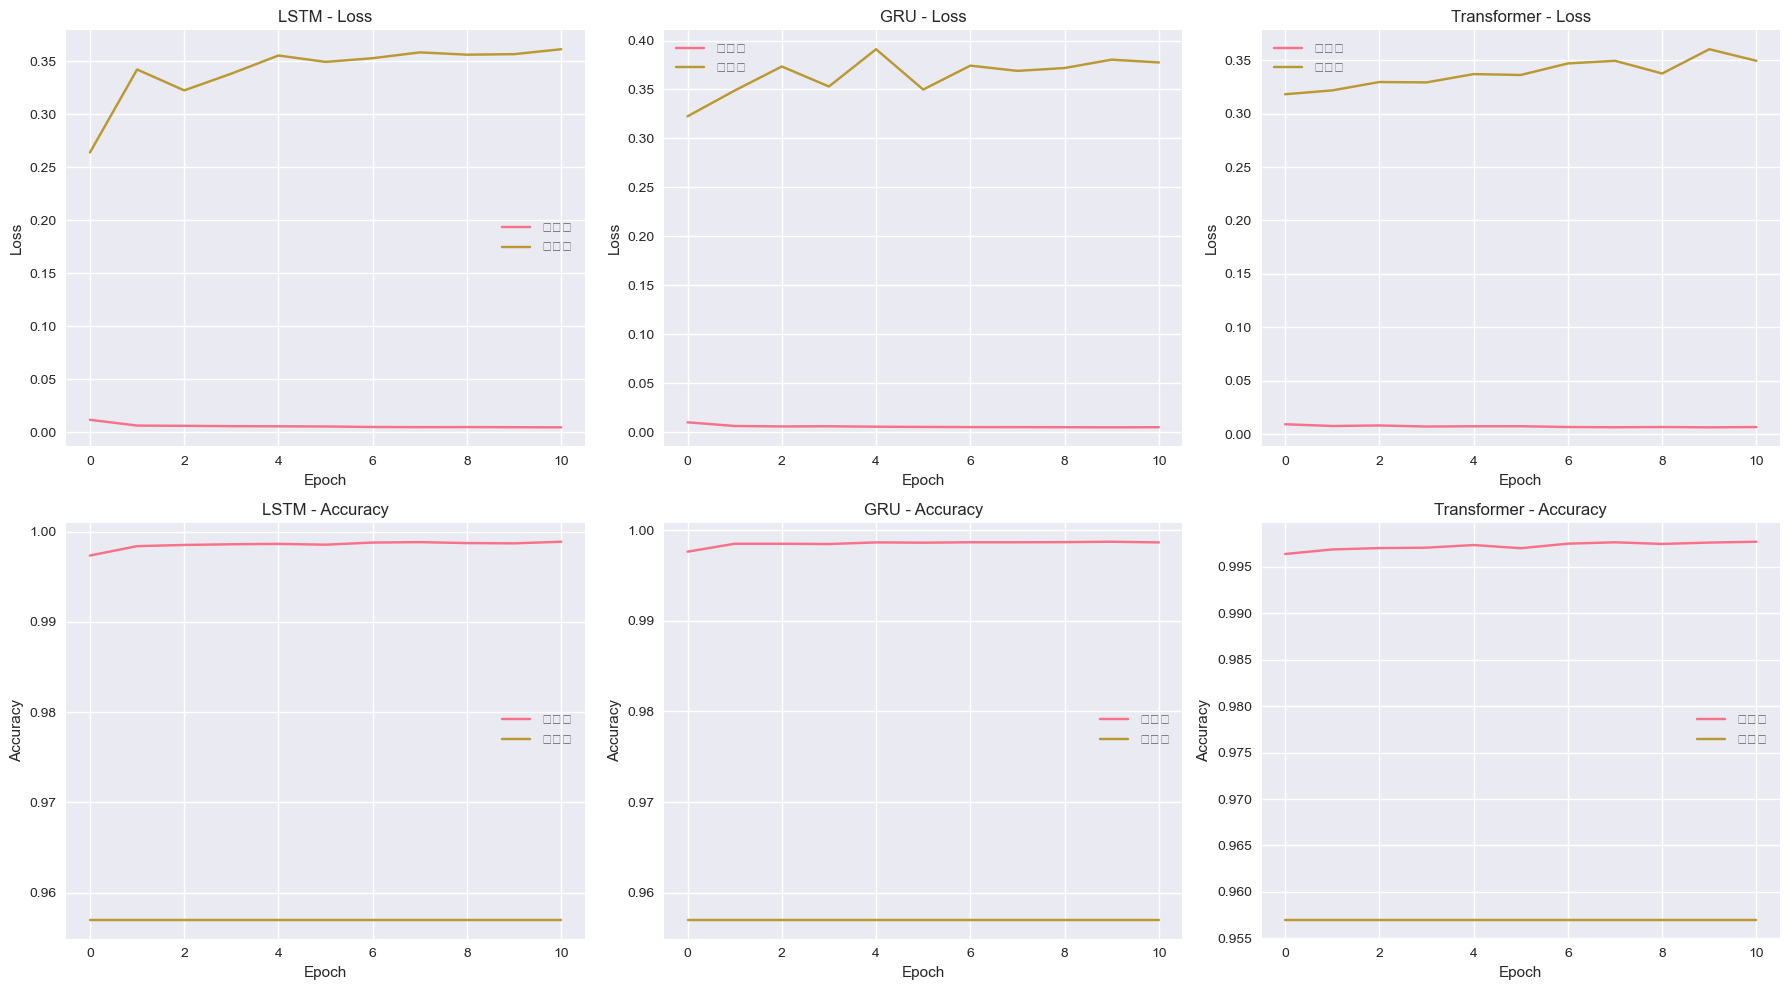

In [9]:
# 绘制训练曲线
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

histories = {
    'LSTM': history_lstm,
    'GRU': history_gru,
    'Transformer': history_transformer
}

for idx, (name, history) in enumerate(histories.items()):
    # Loss曲线
    axes[0, idx].plot(history.history['loss'], label='训练集')
    axes[0, idx].plot(history.history['val_loss'], label='验证集')
    axes[0, idx].set_title(f'{name} - Loss')
    axes[0, idx].set_xlabel('Epoch')
    axes[0, idx].set_ylabel('Loss')
    axes[0, idx].legend()
    axes[0, idx].grid(True)
    
    # Accuracy曲线
    axes[1, idx].plot(history.history['accuracy'], label='训练集')
    axes[1, idx].plot(history.history['val_accuracy'], label='验证集')
    axes[1, idx].set_title(f'{name} - Accuracy')
    axes[1, idx].set_xlabel('Epoch')
    axes[1, idx].set_ylabel('Accuracy')
    axes[1, idx].legend()
    axes[1, idx].grid(True)

plt.tight_layout()
plt.savefig(config.VISUALIZATIONS_DIR / 'training_curves.png', dpi=config.PLOT_DPI, bbox_inches='tight')
plt.show()


## 9. 保存模型和训练历史


In [10]:
# 保存所有模型
lstm_model.save(config.MODELS_DIR / 'lstm_final.h5')
gru_model.save(config.MODELS_DIR / 'gru_final.h5')
transformer_model.save(config.MODELS_DIR / 'transformer_final.h5')

# 保存训练历史
save_intermediate('history_lstm', history_lstm.history)
save_intermediate('history_gru', history_gru.history)
save_intermediate('history_transformer', history_transformer.history)

print("✓ 所有模型和训练历史已保存")


已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\history_lstm.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\history_gru.pkl
已保存: C:\Users\nowan\Downloads\Shared_with_EECS215_Fall2025\outputs\intermediate\history_transformer.pkl
✓ 所有模型和训练历史已保存
